### library import

In [29]:
import numpy as np
import scipy.misc as scm
import math
import random
from scipy.stats import poisson
from sympy import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Modelingクラス

In [30]:
class Modeling:

    def __init__(self,lambda_poisson, repeat):
        self.lambda_poisson = lambda_poisson
        self.collecting_deadline = lambda_poisson * 2
        self.repeat = repeat
        self.poisson = np.random.poisson(lambda_poisson, 1000)

    def half_num(self,num):
        return int(math.ceil(float(num) / 2))

    def simulate_when_people_come_list(self, people_num):
        when_people_come = [0] * self.collecting_deadline
        for t in range(people_num):
            when_people_come[t] = 1
        random.shuffle(when_people_come)
        return when_people_come

    def possibility_correct_by_majority_vote(self, people_num, possibility_correct):
        return (1 - self.relative_error_by_majority_vote(people_num, possibility_correct))

    def relative_error_by_majority_vote(self, people_num, possibility_correct):
        half_num = self.half_num(people_num)
        relative_error = 0
        for t in range(half_num):
            relative_error += (possibility_correct**t) * ((1 - possibility_correct)**(people_num - t)) * scm.comb(people_num, t)
        return relative_error

    def possibility_correct_list_by_half_opinion(self, finish_num, possibility_correct):
        possibility_correct_list = []
        for t in range(finish_num):
            possibility_correct_list.append((possibility_correct**finish_num) * ((1 - possibility_correct)**t) * scm.comb(finish_num - 1 + t, t))
        return possibility_correct_list

    def relative_error_list_by_half_opinion(self, finish_num, possibility_correct):
        relative_error = []
        for t in range(finish_num):
            relative_error.append(((1 - possibility_correct)**finish_num) * (possibility_correct**t) * scm.comb(finish_num - 1 + t, t))
        return relative_error

    def method_utility_list_decideing_by_first_person(self, possibility_correct, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - weight * (float(i) / self.collecting_deadline)
                break
            method_utility_list.append(method_utility)
        return method_utility_list

    def method_utility_list_decideing_by_majority_vote(self, possibility_correct, majority_vote_people, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility +=  self.possibility_correct_by_majority_vote(people_count, possibility_correct) - weight * (float(i) / self.collecting_deadline)
                    break
            method_utility_list.append(method_utility)
        return method_utility_list

    def method_utility_list_decideing_by_half_opinion(self, possibility_correct, temp_people_num, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_list = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_list.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    possibility_correct_list = self.possibility_correct_list_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    sum_possibility = sum(possibility_correct_list)
                    average_index = 0
                    for index in range(len(possibility_correct_list)):
                        average_index += people_count_list[self.half_num(temp_people_num) - 1 + index] * (possibility_correct_list[index] / sum_possibility)
                    method_utility = sum_possibility - weight * (float(average_index) / self.collecting_deadline)
                    break
            method_utility_list.append(method_utility)
        return method_utility_list

    def method_utility_list_decideing_by_time_limit(self, possibility_correct, time_limit, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            method_utility_list.append(method_utility)
        return method_utility_list

    def deciding_by_first_person_average(self, possibility_correct, weight):
        method_utility_list = self.method_utility_list_decideing_by_first_person(possibility_correct, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_majority_vote_average(self, possibility_correct, majority_vote_people, weight):
        method_utility_list = self.method_utility_list_decideing_by_majority_vote(possibility_correct, majority_vote_people, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_half_opinion_average(self, possibility_correct, temp_people_num, weight):
        method_utility_list = self.method_utility_list_decideing_by_half_opinion(possibility_correct, temp_people_num, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_time_limit_average(self, possibility_correct, time_limit, weight):
        method_utility_list = self.method_utility_list_decideing_by_time_limit(possibility_correct, time_limit, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_first_person_variance(self, possibility_correct, weight):
        method_utility_list = self.method_utility_list_decideing_by_first_person(possibility_correct, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    def deciding_by_majority_vote_variance(self, possibility_correct, majority_vote_people, weight):
        method_utility_list = self.method_utility_list_decideing_by_majority_vote(possibility_correct, majority_vote_people, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    def deciding_by_half_opinion_variance(self, possibility_correct, temp_people_num, weight):
        method_utility_list = self.method_utility_list_decideing_by_half_opinion(possibility_correct, temp_people_num, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    def deciding_by_time_limit_variance(self, possibility_correct, time_limit, weight):
        method_utility_list = self.method_utility_list_decideing_by_time_limit(possibility_correct, time_limit, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    # 個人の正解率を一様分布で表現する
    # s_possibility ~ s_possibility + t_possibilityまでの一様分布の個人の正解率
    def method_utility_list_decideing_by_first_person_with_uniform_distribution(self, s_possibility, t_possibility, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n] # ポアソン分布したがって来る人数
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                method_utility += possibility_correct - weight * (float(i) / self.collecting_deadline)
                break
            method_utility_list.append(method_utility)
        return method_utility_list

    def method_utility_list_decideing_by_majority_vote_with_uniform_distribution(self, s_possibility, t_possibility, majority_vote_people, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            if people_num < majority_vote_people: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count += 1
                if people_count == majority_vote_people:
                    method_utility += (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
            method_utility_list.append(method_utility)
        return method_utility_list

    def method_utility_list_decideing_by_half_opinion_with_uniform_distribution(self, s_possibility, t_possibility, temp_people_num, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            people_count_list = []
            if people_num < temp_people_num: continue
            for i in range(len(when_people_come)):
                if when_people_come[i] == 0: continue
                people_count_list.append(i)
                people_count += 1
                if people_count == temp_people_num:
                    possibility_correct_list = self.possibility_correct_list_by_half_opinion(self.half_num(temp_people_num), possibility_correct)
                    sum_possibility = sum(possibility_correct_list)
                    average_index = 0
                    for index in range(len(possibility_correct_list)):
                        average_index += people_count_list[self.half_num(temp_people_num) - 1 + index] * (possibility_correct_list[index] / sum_possibility)
                    method_utility = sum_possibility - weight * (float(average_index) / self.collecting_deadline)
                    break
            method_utility_list.append(method_utility)
        return method_utility_list

    def method_utility_list_decideing_by_time_limit_with_uniform_distribution(self, s_possibility, t_possibility, time_limit, weight):
        method_utility_list = []
        for n in range(self.repeat):
            people_num = self.poisson[n]
            possibility_correct = (np.random.rand() * t_possibility + s_possibility) / 100
            when_people_come = self.simulate_when_people_come_list(people_num)
            method_utility = 0
            people_count = 0
            for i in range(len(when_people_come)):
                if i >= time_limit and people_count >= 1:
                    method_utility = (1 - self.relative_error_by_majority_vote(people_count, possibility_correct)) - weight * (float(i) / self.collecting_deadline)
                    break
                if when_people_come[i] == 0: continue
                people_count += 1
            method_utility_list.append(method_utility)
        return method_utility_list

    def deciding_by_first_person_average_with_uniform_distribution(self, s_possibility, t_possibility, weight):
        method_utility_list = self.method_utility_list_decideing_by_first_person_with_uniform_distribution(s_possibility, t_possibility, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_majority_vote_average_with_uniform_distribution(self, s_possibility, t_possibility, majority_vote_people, weight):
        method_utility_list = self.method_utility_list_decideing_by_majority_vote_with_uniform_distribution(s_possibility, t_possibility, majority_vote_people, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_half_opinion_average_with_uniform_distribution(self, s_possibility, t_possibility, temp_people_num, weight):
        method_utility_list = self.method_utility_list_decideing_by_half_opinion_with_uniform_distribution(s_possibility, t_possibility, temp_people_num, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_time_limit_average_with_uniform_distribution(self, s_possibility, t_possibility, time_limit, weight):
        method_utility_list = self.method_utility_list_decideing_by_time_limit_with_uniform_distribution(s_possibility, t_possibility, time_limit, weight)
        average_method_utility = np.mean(method_utility_list)
        return average_method_utility

    def deciding_by_first_person_variance_with_uniform_distribution(self, s_possibility, t_possibility, weight):
        method_utility_list = self.method_utility_list_decideing_by_first_person_with_uniform_distribution(s_possibility, t_possibility, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    def deciding_by_majority_vote_variance_with_uniform_distribution(self, s_possibility, t_possibility, majority_vote_people, weight):
        method_utility_list = self.method_utility_list_decideing_by_majority_vote_with_uniform_distribution(s_possibility, t_possibility, majority_vote_people, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    def deciding_by_half_opinion_variance_with_uniform_distribution(self, s_possibility, t_possibility, temp_people_num, weight):
        method_utility_list = self.method_utility_list_decideing_by_half_opinion_with_uniform_distribution(s_possibility, t_possibility, temp_people_num, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    def deciding_by_time_limit_variance_with_uniform_distribution(self, s_possibility, t_possibility, time_limit, weight):
        method_utility_list = self.method_utility_list_decideing_by_time_limit_with_uniform_distribution(s_possibility, t_possibility, time_limit, weight)
        variance_method_utility = np.var(method_utility_list)
        return variance_method_utility

    # ------------------以下は理論に基づいた実装を行う------------------

    # Poisson過程
    # 単位時間あたりの到着数 λ
    # 時刻tまでにn人が到着する確率
    def poisson_possibility(self, n, t, lambda_poisson):
        return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n / math.factorial(n)

    # Gamma分布
    # 時刻tにn人目が到着する確率
    def gamma_possibility(self, n, t, lambda_poisson):
        return lambda_poisson**n / math.factorial(n - 1) * t**(n - 1) * math.e**(-lambda_poisson * t)

    # 多数決による判定精度
    # n人で多数決を行う場合の判定精度をacc(n)で表す
    # 個人の判定精度をpとする
    def acc_odd(self, n, p): # nが奇数2i-1のとき
        i = int((n + 1) / 2)
        acc = 0
        for j in range(i):
            acc += scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j
        return acc

    def acc_even(self, n, p): # nが偶数2iのとき
        i = int(n / 2)
        acc = 0
        for j in range(i):
            acc += scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j
        acc += scm.comb(2 * i, i) * p**i * (1 - p)**i / 2
        return acc

    def acc(self, n, p):
        if n % 2 == 1:
            return self.acc_odd(n, p)
        else:
            return self.acc_even(n, p)
        
    # 2,単純な意見集約法

    # 時刻優先意見集約法
    # 時刻tまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def time_priority_method(self, t, w, p, lambda_poisson):
        utility = 0
        for i in range(1, lambda_poisson * t):
            utility += self.poisson_possibility(2 * i - 1, t, lambda_poisson) * self.acc_odd(2 * i - 1, p)
            utility += self.poisson_possibility(2 * i, t, lambda_poisson) * self.acc_even(2 * i, p)
        utility -= w * t
        return utility
    
    # 増減を調べる
    def inc_and_dec_time_priority_method(self, w, p, lambda_poisson):
        for t in range(1, 1000):
            diff = self.time_priority_method(t + 1, w, p, lambda_poisson) - self.time_priority_method(t, w, p, lambda_poisson)
            if diff < 0: return t
            
    # 2.2, 投票数優先意見集約法
    # n人集まるまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def poll_priority_method(self, n, w, p, lambda_poisson):
        utility = 0
        utility += self.acc(n, p)
        # 積分を行う
        t = Symbol('t')
        integrand = w * t * self.gamma_possibility(n, t, lambda_poisson) # 被積分関数
        print integrate(integrand, (t, 0, 100))
        utility -= integrate(integrand, (t, 0, 100))
        return utility



### PlotGraphクラス

In [31]:
class PlotGraph:

    def __init__(self, lambda_poisson, repeat):
        self.model = Modeling(lambda_poisson, repeat)

    # 縦軸を誤差率、横軸を個人の正解率
    def plot_error_possibility_graph(self, people_num):
        x_axis = np.linspace(50,100,50)
        y_axis_majority_vote = self.model.relative_error_by_majority_vote(people_num, x_axis / 100)
        y_axis_half_opinion = sum(self.model.relative_error_list_by_half_opinion(self.model.half_num(people_num), x_axis / 100))
        plt.hold(True)
        plt.title('error_possibility_graph %s people' % people_num)
        plt.xlabel('Possibility of correct')
        plt.ylabel('Relative error')
        plt.plot(x_axis, y_axis_majority_vote, label='Majority vote')
        plt.plot(x_axis, y_axis_half_opinion, label='Half opinion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 必要になったら実装
    def plot_cost_error_graph(self):
        pass

    # 人数を変えてグラフを重ねる
    # 縦軸を誤差率、横軸を個人の正解率
    def plot_error_possibility_graph_by_people_num(self):
        x_axis = np.linspace(50,100,50)
        y_axis_list = []
        for t in range(30):
            y_axis_list.append(self.model.relative_error_by_majority_vote(1 + 2 * t, x_axis / 100))
        plt.hold(True)
        plt.title('Error-possibility graph by people number')
        plt.xlabel('Possibility of correct')
        plt.ylabel('Relative error')
        for y_axis in y_axis_list:
            plt.plot(x_axis, y_axis)
        plt.show()

    # 必要になったら実装
    def plot_cost_error_graph_by_possibility(self):
        pass

    # ポアソン分布にしたがって効用の平均を求めたグラフ
    # 縦軸を効用、横軸を個人の正解率
    def plot_utility_possibility_average_graph(self, majority_vote_people, half_opinion_people, time_limit, weight):
        x_axis = np.linspace(0.5,1.0,50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_average(x, weight) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_average(x, majority_vote_people, weight) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_average(x, half_opinion_people, weight) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_average(x, time_limit, weight) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-possibility graph majority vote people:{0} half opinion people:{1} timelimit:{2} weight:{3}'.format(majority_vote_people, half_opinion_people, time_limit, weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # ポアソン分布にしたがって効用の分散を求めたグラフ
    # 縦軸を効用の分散、横軸を個人の正解率
    def plot_utility_possibility_variance_graph(self, majority_vote_people, half_opinion_people, time_limit, weight):
        x_axis = np.linspace(0.5,1.0,50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_variance(x, weight) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_variance(x, majority_vote_people, weight) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_variance(x, half_opinion_people, weight) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_variance(x, time_limit, weight) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-possibility graph majority vote people:{0} half opinion people:{1} timelimit:{2} weight:{3}'.format(majority_vote_people, half_opinion_people, time_limit, weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 重みを0.0,,,1.0と遷移させていったときの効用の平均
    # 縦軸を効用、横軸を重み
    def plot_utility_weight_average_graph(self, possibility_correct, majority_vote_people, half_opinion_people, time_limit):
        x_axis = np.linspace(0.0, 1.0, 50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_average(possibility_correct, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_average(possibility_correct, majority_vote_people, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_average(possibility_correct, half_opinion_people, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_average(possibility_correct, time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph majority vote people:{0} half opinion people:{1} timelimit:{2} possibility_correct:{3}'.format(majority_vote_people, half_opinion_people, time_limit, possibility_correct))
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 重みを0.0,,,1.0と遷移させていったときの効用の分散
    # 縦軸を効用、横軸を重み
    def plot_utility_weight_variance_graph(self, possibility_correct, majority_vote_people, half_opinion_people, time_limit):
        x_axis = np.linspace(0.0, 1.0, 50)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_variance(possibility_correct, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_variance(possibility_correct, majority_vote_people, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_variance(possibility_correct, half_opinion_people, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_variance(possibility_correct, time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph majority vote people:{0} half opinion people:{1} timelimit:{2} possibility_correct:{3}'.format(majority_vote_people, half_opinion_people, time_limit, possibility_correct))
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 多数決を行う人数や時間制限どれくらいが最適であるか
    # ポアソン分布の平均にも依存すると考えられる
    # 平均
    # 縦軸を効用、横軸を個人の正解率
    def plot_utility_possibility_average_graph_for_single_method(self, weight):
        x_axis = np.linspace(0.5, 1.0, 50)
        # 最初の一人
        y_axis_dict = {}
        y_axis_dict["First person"] = [self.model.deciding_by_first_person_average(x, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 多数決
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Majority vote" + str(2 * t + 1)] = [self.model.deciding_by_majority_vote_average(x, 2 * t + 1, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 半数
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Half opinion" + str(2 * t + 1)] = [self.model.deciding_by_half_opinion_average(x, 2 * t + 1, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 時間打ち切り
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Time limit" + str(4 * t + 1)] = [self.model.deciding_by_time_limit_average(x, 4 * t + 1, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 多数決を行う人数や時間制限どれくらいが最適であるか
    # ポアソン分布の平均にも依存すると考えられる
    # 分散
    # 縦軸を効用、横軸を個人の正解率
    def plot_utility_possibility_variance_graph_for_single_method(self, weight):
        x_axis = np.linspace(0.5, 1.0, 50)
        # 最初の一人
        y_axis_dict = {}
        y_axis_dict["First person"] = [self.model.deciding_by_first_person_variance(x, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 多数決
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Majority vote" + str(2 * t + 1)] = [self.model.deciding_by_majority_vote_variance(x, 2 * t + 1, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 半数
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Half opinion" + str(2 * t + 1)] = [self.model.deciding_by_half_opinion_variance(x, 2 * t + 1, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 時間打ち切り
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Time limit" + str(4 * t + 1)] = [self.model.deciding_by_time_limit_variance(x, 4 * t + 1, weight) for x in x_axis]
        plt.title('Utility-possibility graph weight: {}'.format(weight))
        plt.xlabel('Possibility correct')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()


    # 個人の正答率を一様分布で表したもの
    # 縦軸を効用、横軸を重み
    # 平均
    def plot_utility_weight_average_graph_with_uniform_distribution(self, s_possibility, t_possibility, majority_vote_people, half_opinion_people, time_limit):
        x_axis = np.linspace(0.0, 1.0, 20)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_average_with_uniform_distribution(s_possibility, t_possibility, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_average_with_uniform_distribution(s_possibility, t_possibility, majority_vote_people, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_average_with_uniform_distribution(s_possibility, t_possibility, half_opinion_people, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_average_with_uniform_distribution(s_possibility, t_possibility, time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph uniform distribution majority vote people:{0} halp opinion people: {1} timelimit:{2} possibility_correct:{3}~{4}'.format(majority_vote_people, half_opinion_people, time_limit, s_possibility, s_possibility + t_possibility ))
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 個人の正答率を一様分布で表したもの
    # 縦軸を効用、横軸を重み
    # 分散
    def plot_utility_weight_variance_graph_with_uniform_distribution(self, s_possibility, t_possibility, majority_vote_people, half_opinion_people, time_limit):
        x_axis = np.linspace(0.0, 1.0, 20)
        y_axis_dict = {}
        y_axis_dict["First peson"] = [self.model.deciding_by_first_person_variance_with_uniform_distribution(s_possibility, t_possibility, x) for x in x_axis]
        y_axis_dict["Majority vote"] = [self.model.deciding_by_majority_vote_variance_with_uniform_distribution(s_possibility, t_possibility, majority_vote_people, x) for x in x_axis]
        y_axis_dict["Half opinion"] = [self.model.deciding_by_half_opinion_variance_with_uniform_distribution(s_possibility, t_possibility, half_opinion_people, x) for x in x_axis]
        y_axis_dict["Time limit"] = [self.model.deciding_by_time_limit_variance_with_uniform_distribution(s_possibility, t_possibility, time_limit, x) for x in x_axis]
        plt.hold(True)
        plt.title('Utility-weight graph uniform distribution majority vote people:{0} halp opinion people: {1} timelimit:{2} possibility_correct:{3}~{4}'.format(majority_vote_people, half_opinion_people, time_limit, s_possibility, s_possibility + t_possibility ))
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 多数決を行う人数や時間制限どれくらいが最適であるか
    # ポアソン分布の平均にも依存すると考えられる
    # 確率を一様分布として扱う
    # 平均
    # 縦軸を効用の平均、横軸を重み
    def plot_utility_weight_average_graph_with_uniform_distribution_for_single_method(self, s_possibility, t_possibility):
        x_axis = np.linspace(0.0, 1.0, 20)
        # 最初の一人
        y_axis_dict = {}
        y_axis_dict["First person"] = [self.model.deciding_by_first_person_average_with_uniform_distribution(s_possibility, t_possibility, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 多数決
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Majority vote" + str(2 * t + 1)] = [self.model.deciding_by_majority_vote_average_with_uniform_distribution(s_possibility, t_possibility, 2 * t + 1, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 半数
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Half opinion" + str(2 * t + 1)] = [self.model.deciding_by_half_opinion_average_with_uniform_distribution(s_possibility, t_possibility, 2 * t + 1, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 時間打ち切り
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Time limit" + str(4 * t + 1)] = [self.model.deciding_by_time_limit_average_with_uniform_distribution(s_possibility, t_possibility, 4 * t + 1, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Utility')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()

    # 多数決を行う人数や時間制限どれくらいが最適であるか
    # ポアソン分布の平均にも依存すると考えられる
    # 確率を一様分布として扱う
    # 分散
    # 縦軸を効用の分散、横軸を重み
    def plot_utility_weight_variance_graph_with_uniform_distribution_for_single_method(self, s_possibility, t_possibility):
        x_axis = np.linspace(0.0, 1.0, 20)
        # 最初の一人
        y_axis_dict = {}
        y_axis_dict["First person"] = [self.model.deciding_by_first_person_variance_with_uniform_distribution(s_possibility, t_possibility, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 多数決
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Majority vote" + str(2 * t + 1)] = [self.model.deciding_by_majority_vote_variance_with_uniform_distribution(s_possibility, t_possibility, 2 * t + 1, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 半数
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Half opinion" + str(2 * t + 1)] = [self.model.deciding_by_half_opinion_variance_with_uniform_distribution(s_possibility, t_possibility, 2 * t + 1, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()
        # 時間打ち切り
        y_axis_dict = {}
        for t in range(10):
            y_axis_dict["Time limit" + str(4 * t + 1)] = [self.model.deciding_by_time_limit_variance_with_uniform_distribution(s_possibility, t_possibility, 4 * t + 1, x) for x in x_axis]
        plt.title('Utility-possibility graph possibility_correct:{0}~{1}'.format(s_possibility, s_possibility + t_possibility))
        plt.xlabel('weight')
        plt.ylabel('Variance')
        for key, value in y_axis_dict.iteritems():
            plt.plot(x_axis, value, label = key)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
        plt.show()


### main

In [32]:
sns.set_style("whitegrid")
# pg = PlotGraph(50, 2)
# pg.plot_error_possibility_graph(5)
# pg.plot_error_possibility_graph_by_people_num()
# pg.plot_utility_possibility_average_graph(11, 13, 17, 0.5)
# pg.plot_utility_possibility_variance_graph(11, 13, 17, 0.5)
# pg.plot_utility_weight_average_graph(0.7, 11, 13, 17)
# pg.plot_utility_weight_variance_graph(0.7, 11, 13, 17)
# pg.plot_utility_possibility_average_graph_for_single_method(0.5)
# pg.plot_utility_possibility_variance_graph_for_single_method(0.5)
# pg.plot_utility_weight_average_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_average_graph_with_uniform_distribution_for_single_method(50, 50)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution_for_single_method(50, 50)

0.00250000000000000
0.00500000000000000
0.00750000000000000
0.00984375000000000
0.0123046875000000
0.0149414062500000
0.0169189453125000
0.0199951171875000
0.0207641601562500
0.0173034667968750
0.0237922668457031
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


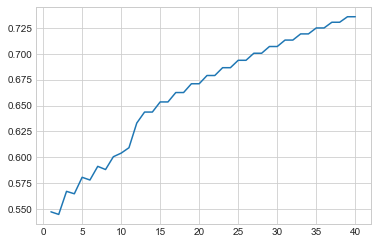

11

In [34]:
m = Modeling(0,0)

# x_axis = np.linspace(1,99,99)
# y_axis_poisson=[]
# y_axis_gamma=[]
# for x in x_axis:
#     y_axis_poisson.append(m.poisson_possibility(x, 10, 5))
#     y_axis_gamma.append(m.gamma_possibility(x,10,5))
# plt.plot(x_axis, y_axis_poisson, label='p')
# plt.plot(x_axis, y_axis_gamma, label='g')
# plt.legend()
# plt.show()

x_axis = np.linspace(1, 40, 40)
y_axis_time_priority =  [m.poll_priority_method(int(x), 0.01, 0.55, 4) for x in x_axis]
plt.plot(x_axis, y_axis_time_priority)
plt.legend()
plt.show()

# init_printing()      # 出力を整形

# x = Symbol('x')                  # 文字'x'を変数xとして定義

# grad = diff(m.time_priority_method(x, 0.01, 0.7, 2), x)
# grad
# grad.subs([(x, 10)])

m.inc_and_dec_time_priority_method(0.01, 0.55, 4)